In [5]:
import ssl
import pandas as pd
from tensortrade.utils import CryptoDataDownload
import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context  # Only used if pandas gives a SSLError
cdd = CryptoDataDownload()

data = pd.concat([
    cdd.fetch("Coinbase", "USD", "BTC", "1h").add_prefix("BTC:"),
], axis=1)
data = data.rename({"BTC:date": "date"}, axis=1)

In [6]:
# ## Create features with the data module


from tensortrade.data import Node, Module, DataFeed, Stream, Select


def rsi(price: Node, period: float):
    r = price.diff()
    upside = r.clamp_min(0).abs()
    downside = r.clamp_max(0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100 * (1 - (1 + rs) ** -1)


def macd(price: Node, fast: float, slow: float, signal: float) -> Node:
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal


features = []
for c in data.columns[1:]:
    s = Stream(list(data[c])).rename(data[c].name)
    features += [s]

btc_close = Select("BTC:close")(*features)
# eth_close = Select("ETH:close")(*features)

features += [
    rsi(btc_close, period=20).rename("BTC:rsi"),
    macd(btc_close, fast=10, slow=50, signal=5).rename("BTC:macd"),
#    rsi(eth_close, period=20).rename("ETH:rsi"),
#    macd(eth_close, fast=10, slow=50, signal=5).rename("ETH:macd")
]

feed = DataFeed(features)
feed.compile()

## In[3]:
# Unknown step yet, investigate

feed.next()

/Users/julien/code/tensortrade/tensortrade/data/stream/node.py:933: RuntimeWarning:

invalid value encountered in double_scalars



{'BTC:open': 2505.56,
 'BTC:high': 2513.38,
 'BTC:low': 2495.12,
 'BTC:close': 2509.17,
 'BTC:volume': 287000.32,
 'BTC:rsi': nan,
 'BTC:macd': 0.0}

In [34]:
# Setup exchange, portfolio trading environment
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, DataFeed, Module
from tensortrade.instruments import USD, BTC
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.environments import TradingEnvironment

coinbase = Exchange("coinbase", service=execute_order)(
    Stream(list(data["BTC:close"])).rename("USD-BTC"),
    # Stream(list(data["ETH:close"])).rename("USD-ETH")
)

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 0 * BTC),
    # Wallet(coinbase, 5 * ETH),
])

price_history = data[['BTC:open', 'BTC:close', 'BTC:high', 'BTC:low', 'BTC:volume', 'date']].copy()
price_history = price_history.rename(
    columns={"BTC:open": "open", "BTC:close": "close", "BTC:high": "high", "BTC:low": "low", "BTC:volume": "volume",
             "date": "datetime"})

env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    use_internal=False,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    window_size=20,
    enable_logger=False,
    renderers=['screenlog'],
    price_history=price_history
)

# ## Example Data Feed Observation
#
# Even though this observation contains data from the internal data feed, since `use_internal=False` this data will not be provided as input to the observation history. The data that will be added to observation history of the environment will strictly be the nodes that have been included into the data feed that has been provided as a parameter to the trading environment.

env.feed.next()

# ## Setup and Train DQN Agent

## In[6]:
# Train agent and plot result

from tensortrade.agents import DQNAgent

agent = DQNAgent(env)

agent.train(n_steps=70, n_episodes=3, save_path="./agents/")

====      AGENT ID: 47295dd9-fcf5-4a52-9607-3e74068793a8      ====
[2020-05-31 11:15:11 AM] Episode: 2/3 Step: 50/70
[2020-05-31 11:15:15 AM] Episode: 3/3 Step: 50/70


3.8285714285714287

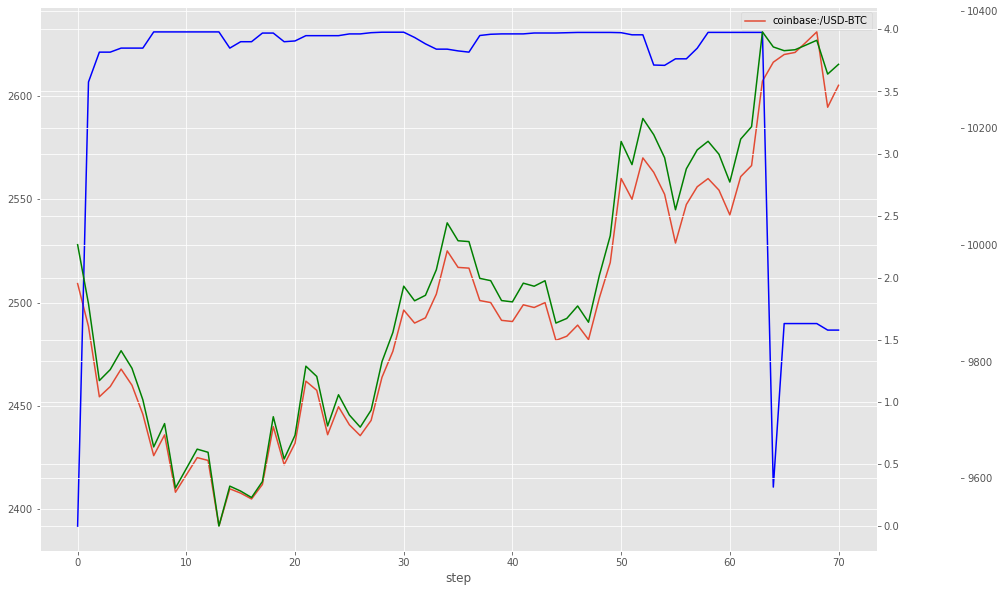

In [35]:
# ## Plot Performance
# data.loc[1:100, 'BTC:open'].plot()
# filter_col = [col for col in portfolio._performance if col.startswith('BTC')]
ax = portfolio.performance.loc[:,
     [
         'coinbase:/USD-BTC',
     ]].plot(figsize = (15,10))
ax2=ax.twinx()
ax2.spines['right'].set_position(('axes', '1.0'))

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', '1.1'))

portfolio.performance.loc[:, 'coinbase:/BTC:/locked'].plot(ax=ax2, color='blue')
portfolio.performance.net_worth.plot(ax=ax3, color='green')
# plt.title("Net worth" + str(portfolio.profit_loss))
plt.show()
# portfolio.ledger.as_frame()